In [54]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing, ETSModel, seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
# Custom modules
# from scripts.plotting import *
# from scripts.utils import *
# Plot defaults
px.defaults.height = 400; px.defaults.width = 620
plt.style.use(plt.style.available[4]); plt.rcParams.update({"font.size": 16, "figure.figsize": (20,5), "lines.linewidth": 2})

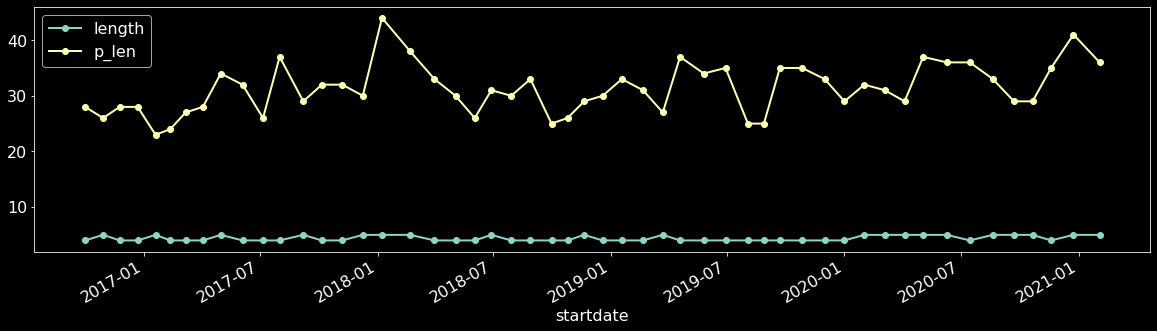

In [2]:
df = pd.read_csv('data/sis.csv', index_col=0, parse_dates=True)
df.plot.line(marker='o')
plt.show()

In [4]:
df1 = df.resample("1M").mean()
df1 = df1.interpolate(method="linear")
df1;

In [24]:
df_train, df_valid = df1[:'2019'], df1['2020':]
df_valid;

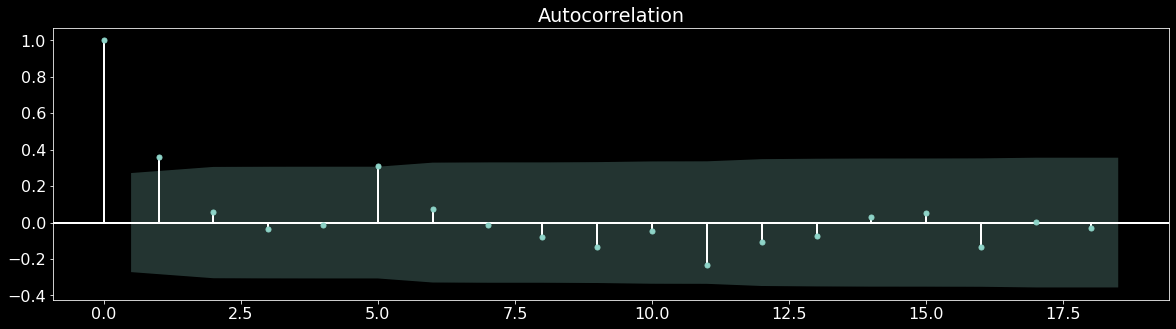

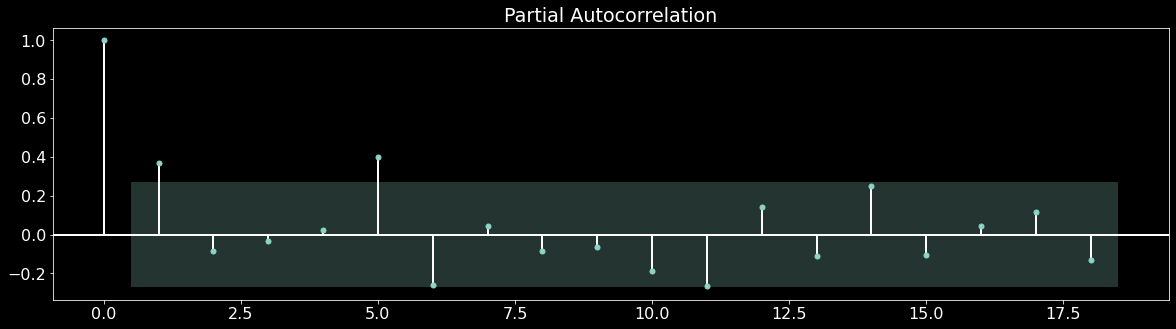

In [25]:
plot_acf(df.p_len), plot_pacf(df.p_len);
# not too much autocorr, so p=1, q = 1,d=1??

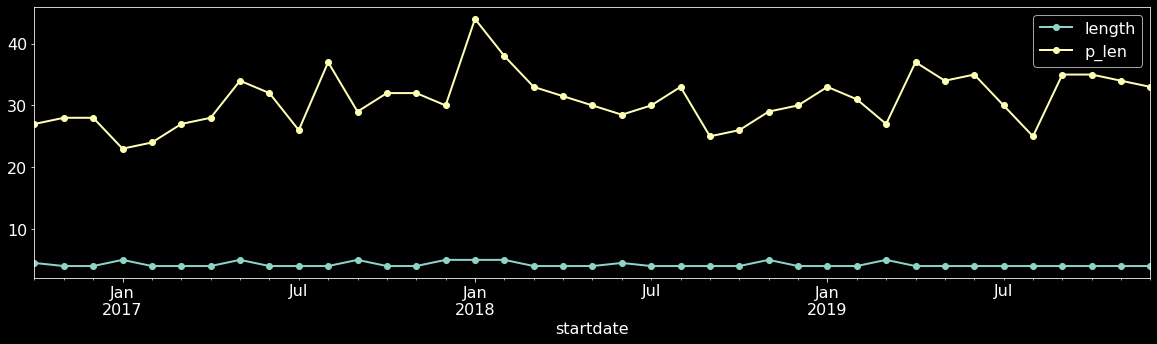

In [27]:
df_train.plot.line(marker='o');

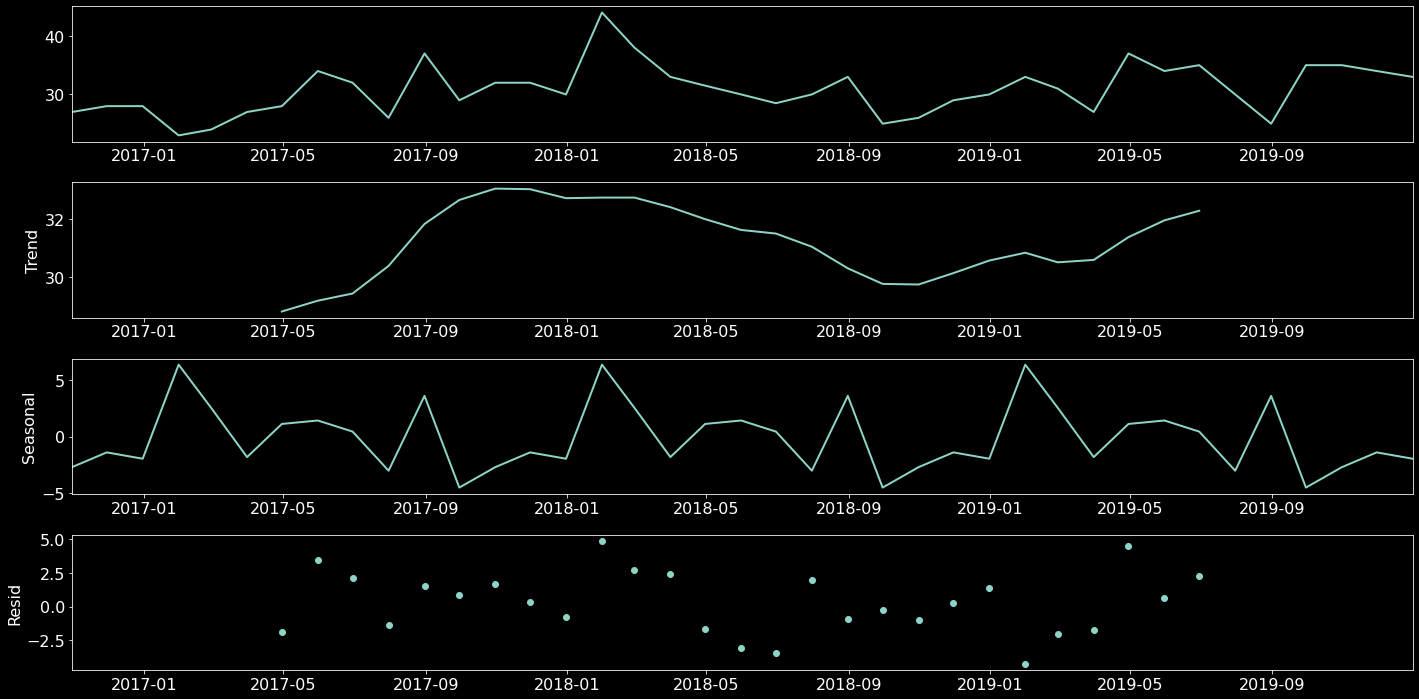

In [28]:
model = seasonal_decompose(df_train[["p_len"]], model="add", period=12)
with plt.rc_context():
    plt.rc("figure", figsize=(20, 10),)
    model.plot(); 
plt.tight_layout()

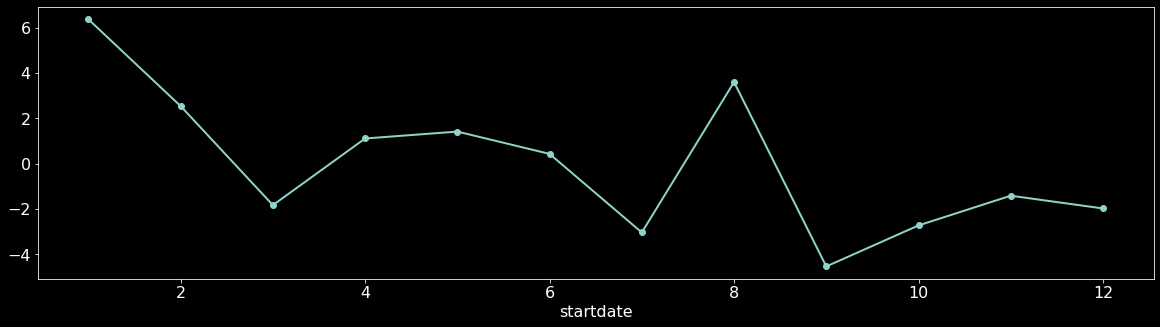

In [30]:
seasonal = model.seasonal.groupby(model.seasonal.index.month).mean()
seasonal.plot.line(marker = 'o');

In [36]:
def create_forecast_index(start, horizon=30, freq="M"):
    return pd.date_range(start + pd.tseries.frequencies.to_offset(freq), periods=horizon, freq=freq, name="Time")
forecast_index=create_forecast_index(df_train.index[-1])

In [37]:
df_train.tail()

,length,p_len
startdate,,
2019-08-31,4.0,25.0
2019-09-30,4.0,35.0
2019-10-31,4.0,35.0
2019-11-30,4.0,34.0
2019-12-31,4.0,33.0


C:\Users\dengj\Miniconda3\envs\mds574\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
C:\Users\dengj\Miniconda3\envs\mds574\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


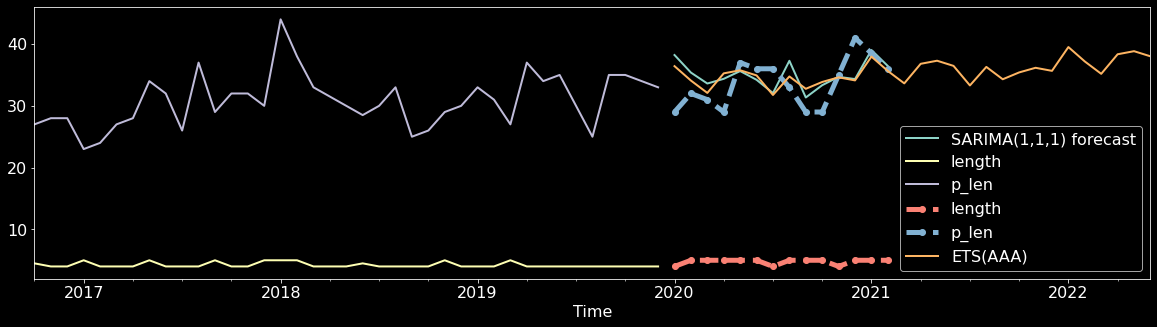

In [78]:
model_arima = ARIMA(df_train["p_len"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
arima = pd.DataFrame({"SARIMA(1,1,1) forecast": model_arima.forecast(len(df_valid.index)),},
                     index=df_valid.index)
ax1 = arima.plot.line()
ax2 = df_train.plot.line(ax=ax1)
ax3 = df_valid.plot.line(ax=ax1, marker='o', linewidth=5, linestyle='--')
ets.plot.line(ax=ax1)
plt.show()

In [58]:
arima;

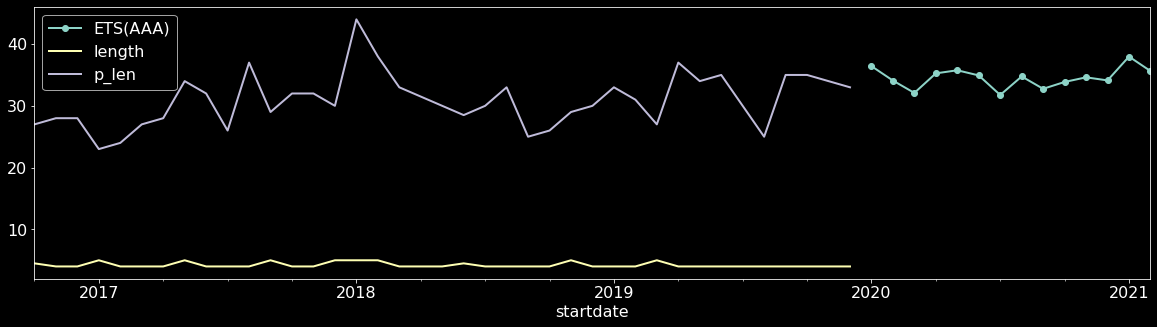

In [82]:

# ETS
model = ETSModel(df_train["p_len"], error="add", trend="add", seasonal="add",
                ).fit()
ets = pd.DataFrame({"ETS(AAA)": model.forecast(len(df_valid.index)),
                    "Label": "ETS"},
                   index=df_valid.index)
ax1 = ets.plot.line(marker='o')
df_train.plot.line(ax=ax1)
plt.show()

In [88]:
ets_2022 = pd.DataFrame({"ETS(AAA)": model.forecast(len(forecast_index)),
                    "Label": "ETS"},
                   index=forecast_index)
ets_2022["2021":]

,ETS(AAA),Label
Time,,
2021-01-31,37.970674,ETS
2021-02-28,35.637100,ETS
2021-03-31,33.636740,ETS
2021-04-30,36.803061,ETS
2021-05-31,37.302766,ETS
2021-06-30,36.469199,ETS
2021-07-31,33.302260,ETS
2021-08-31,36.301932,ETS
2021-09-30,34.301777,ETS


In [80]:
df_valid.head()

,length,p_len
startdate,,
2020-01-31,4.0,29.0
2020-02-29,5.0,32.0
2020-03-31,5.0,31.0
2020-04-30,5.0,29.0
2020-05-31,5.0,37.0


In [83]:
res = {}
for m in [arima, ets]:
    mape = mean_absolute_percentage_error(m.iloc[:, 0], df_valid.iloc[:, 1])
    res[f"{m.columns[0]}"] = [mape]
    
mape_df = pd.DataFrame(res).T.rename(columns={0: "MAPE (ascending)"}).sort_values("MAPE (ascending)")
mape_df

,MAPE (ascending)
ETS(AAA),0.087267
"SARIMA(1,1,1) forecast",0.095262
